<a href="https://colab.research.google.com/github/estrelasdomackenzie/Projeto_Aplicado_III_Tecnologia_em_Ciencia_de_Dados/blob/main/Aplicando_Conhecimento_A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Sistema de Recomendação de Médicos Especialistas
Mackenzie - Projeto Aplicado III

Registros carregados: 246,945

Top 10 doenças mais frequentes:
 1. cystitis                                 1219 casos
 2. vulvodynia                               1218 casos
 3. nose disorder                            1218 casos
 4. complex regional pain syndrome           1217 casos
 5. spondylosis                              1216 casos
 6. esophagitis                              1215 casos
 7. conjunctivitis due to allergy            1215 casos
 8. hypoglycemia                             1215 casos
 9. peripheral nerve disorder                1215 casos
10. vaginal cyst                             1215 casos

Otimização do K
K =  3 | Acurácia = 0.8057 (80.57%)
K =  5 | Acurácia = 0.8149 (81.49%)
K =  7 | Acurácia = 0.8186 (81.86%)
K =  9 | Acurácia = 0.8197 (81.97%)
K = 11 | Acurácia = 0.8208 (82.08%)
K = 13 | Acurácia = 0.8213 (82.13%)
K = 15 | Acurácia = 0.8208 (82.08%)
Melhor K = 13 (Acurácia 

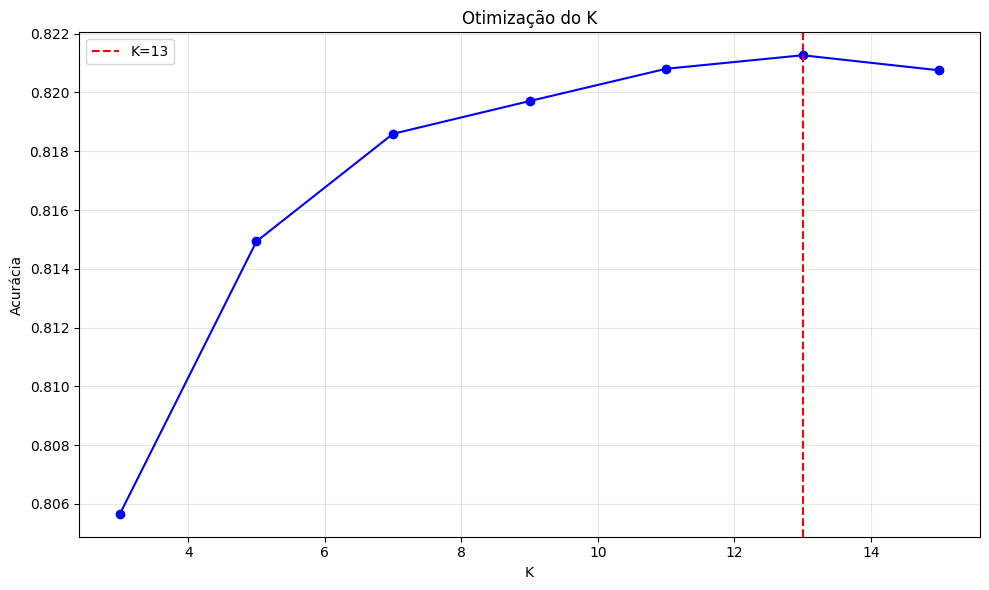


Avaliação do Modelo

Métricas de Performance:
Acurácia:  0.8206 (82.06%)
Precisão:  0.8258 (82.58%)
Recall:    0.8206 (82.06%)
F1-Score:  0.8210 (82.10%)

AUC-ROC (5 doenças mais comuns):
nose disorder                      : 0.9565
vulvodynia                         : 0.9873
cystitis                           : 0.9123
spondylosis                        : 0.9234
conjunctivitis due to allergy      : 0.9625

Comparação com baselines:
KNN:            0.8206
Aleatório:      0.0026
Popularidade:   0.0049
Ganho:          +81.56%

Desempenho por doença (top 10):

Doença                              | Prec. | Recall | F1
------------------------------------------------------------
nose disorder                       | 0.881 | 0.848  | 0.864
vulvodynia                          | 0.919 | 0.881  | 0.900
cystitis                            | 0.755 | 0.668  | 0.709
spondylosis                         | 0.764 | 0.626  | 0.688
conjunctivitis due to allergy       | 0.870 | 0.827  | 0.848
acute bronchi

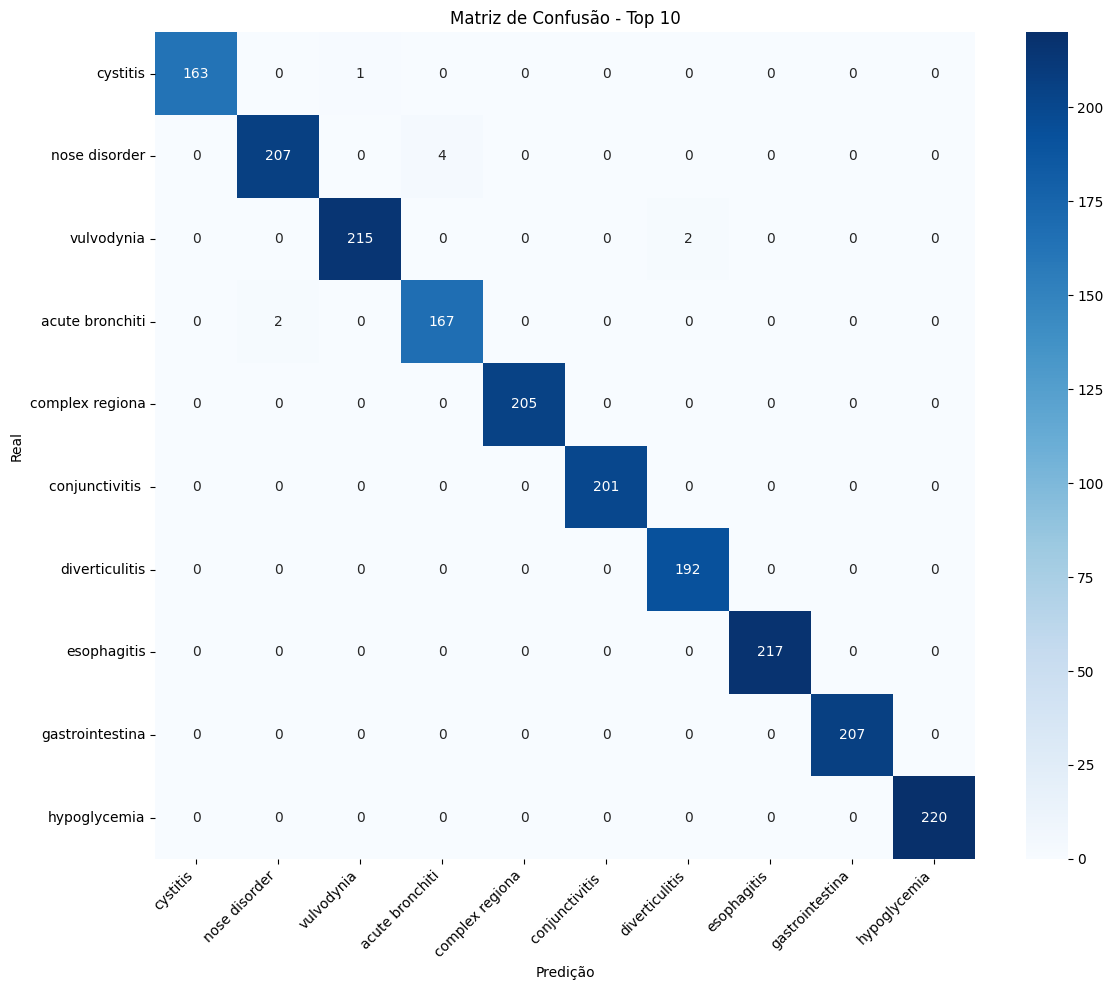

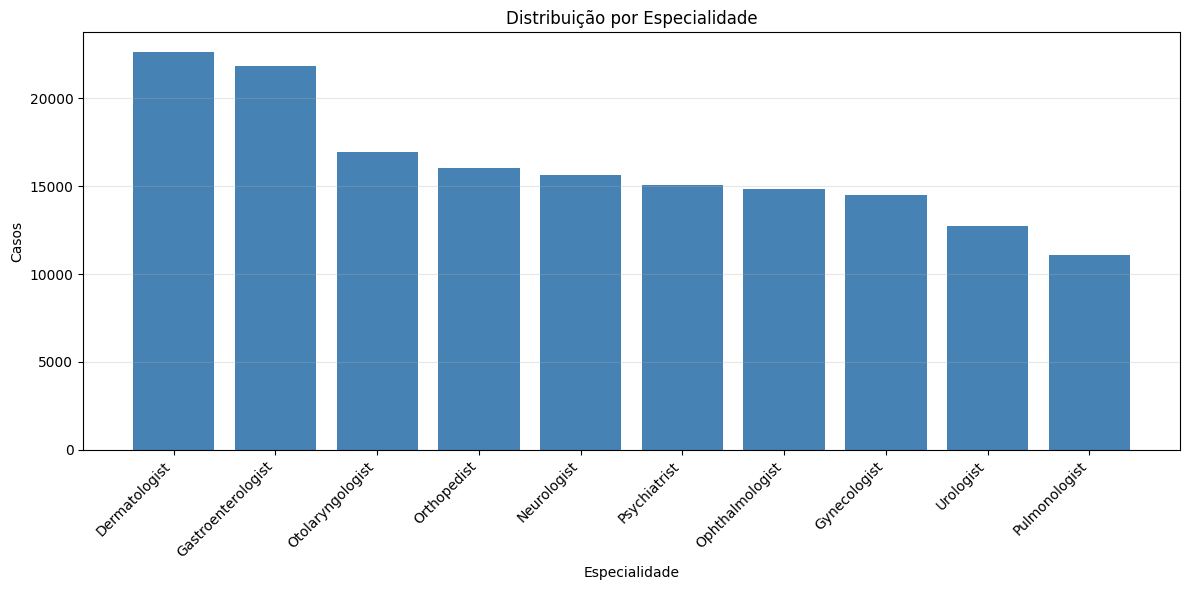


Teste do Sistema

Diagnóstico: panic disorder
Especialista: Psychiatrist
Confiança: 100.0%

Diagnósticos similares:
1. panic disorder
2. panic disorder
3. panic disorder
4. panic disorder
5. panic disorder

Concluído



In [3]:
# -*- coding: utf-8 -*-
"""
Sistema de Recomendação de Médicos Especialistas
Universidade Presbiteriana Mackenzie
Projeto Aplicado III
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from difflib import SequenceMatcher
from collections import Counter

warnings.filterwarnings('ignore')

MAX_K = 15
CV_FOLDS = 3

class SistemaRecomendacaoMedica:

    def __init__(self, k=5):
        self.k = k
        self.modelo = None
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='mean')
        self.encoder = LabelEncoder()
        self.colunas_sintomas = []
        self.dataset = None
        self.metricas = {}
        self.mapa_especialidades = {}

    def _similaridade_strings(self, str1, str2):
        return SequenceMatcher(None, str1.lower(), str2.lower()).ratio()

    def _buscar_match_parcial(self, doenca, mapa_csv, threshold=0.6):
        melhor_match = None
        melhor_score = threshold
        doenca_lower = doenca.lower()
        palavras_doenca = set(doenca_lower.split())

        for doenca_csv, especialista in mapa_csv.items():
            doenca_csv_lower = doenca_csv.lower()
            palavras_csv = set(doenca_csv_lower.split())

            if palavras_doenca & palavras_csv:
                score = len(palavras_doenca & palavras_csv) / max(len(palavras_doenca), len(palavras_csv))
                if score > melhor_score:
                    melhor_score = score
                    melhor_match = especialista

            if doenca_lower in doenca_csv_lower or doenca_csv_lower in doenca_lower:
                score = min(len(doenca_lower), len(doenca_csv_lower)) / max(len(doenca_lower), len(doenca_csv_lower))
                if score > melhor_score:
                    melhor_score = score
                    melhor_match = especialista

            sim = self._similaridade_strings(doenca, doenca_csv)
            if sim > melhor_score:
                melhor_score = sim
                melhor_match = especialista

        return melhor_match, melhor_score if melhor_match else (None, 0)

    def carregar_dados(self, arquivo_sintomas, arquivo_especialidades=None):
        self.dataset = pd.read_csv(arquivo_sintomas)
        total = len(self.dataset)
        print(f"\nRegistros carregados: {total:,}")

        self.colunas_sintomas = [col for col in self.dataset.columns if col != 'diseases']

        if arquivo_especialidades:
            self._carregar_especialidades(arquivo_especialidades)
        else:
            self._mapear_especialidades_automatico()

    def _carregar_especialidades(self, arquivo):
        df = None
        for enc in ['utf-8', 'latin-1', 'cp1252']:
            try:
                df = pd.read_csv(arquivo, encoding=enc)
                break
            except:
                continue
        if df is None:
            return

        df.columns = df.columns.str.strip()
        if 'Disease' not in df.columns or 'Specialist' not in df.columns:
            return

        mapa_csv = {str(row['Disease']).strip(): str(row['Specialist']).strip()
                    for _, row in df.iterrows() if pd.notna(row['Disease']) and pd.notna(row['Specialist'])}

        for doenca in self.dataset['diseases'].unique():
            if doenca in mapa_csv:
                self.mapa_especialidades[doenca] = mapa_csv[doenca]
            else:
                match_case = False
                for d_csv, e_csv in mapa_csv.items():
                    if d_csv.lower() == doenca.lower():
                        self.mapa_especialidades[doenca] = e_csv
                        match_case = True
                        break
                if not match_case:
                    especialista, _ = self._buscar_match_parcial(doenca, mapa_csv)
                    self.mapa_especialidades[doenca] = especialista or 'Clínico Geral'

    def _mapear_especialidades_automatico(self):
        for doenca in self.dataset['diseases'].unique():
            self.mapa_especialidades[doenca] = 'Clínico Geral'

    def analise_dados(self):
        top = self.dataset['diseases'].value_counts().head(10)
        print("\nTop 10 doenças mais frequentes:")
        for i, (doenca, count) in enumerate(top.items(), 1):
            print(f"{i:2}. {doenca[:40]:<40} {count:4} casos")

    def preparar_dados(self):
        X = self.dataset[self.colunas_sintomas].values
        y = self.dataset['diseases'].values

        contagem = Counter(y)
        classes_raras = [c for c, n in contagem.items() if n < 2]
        if classes_raras:
            mask = ~self.dataset['diseases'].isin(classes_raras)
            X = self.dataset[mask][self.colunas_sintomas].values
            y = self.dataset[mask]['diseases'].values

        X = self.imputer.fit_transform(X)
        y_encoded = self.encoder.fit_transform(y)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )

        X_train = self.scaler.fit_transform(X_train)
        X_test = self.scaler.transform(X_test)

        return X_train, X_test, y_train, y_test

    def otimizar_k(self, X_train, y_train):
        k_valores = list(range(3, MAX_K + 1, 2))
        scores = []

        print("\n" + "="*50)
        print("Otimização do K")
        print("="*50)

        for k in k_valores:
            score = cross_val_score(KNeighborsClassifier(n_neighbors=k, n_jobs=-1),
                                   X_train, y_train, cv=CV_FOLDS).mean()
            scores.append(score)
            print(f"K = {k:2d} | Acurácia = {score:.4f} ({score*100:.2f}%)")

        melhor_k = k_valores[np.argmax(scores)]
        melhor_score = max(scores)

        print("="*50)
        print(f"Melhor K = {melhor_k} (Acurácia = {melhor_score:.4f})")
        print("="*50 + "\n")

        plt.figure(figsize=(10, 6))
        plt.plot(k_valores, scores, 'b-o')
        plt.xlabel('K')
        plt.ylabel('Acurácia')
        plt.title('Otimização do K')
        plt.grid(True, alpha=0.3)
        plt.axvline(melhor_k, color='r', linestyle='--', label=f'K={melhor_k}')
        plt.legend()
        plt.tight_layout()
        plt.show()

        self.k = melhor_k
        return melhor_k

    def treinar(self, X_train, y_train):
        self.modelo = KNeighborsClassifier(
            n_neighbors=self.k,
            weights='distance',
            n_jobs=-1
        )
        self.modelo.fit(X_train, y_train)

    def avaliar(self, X_test, y_test):
        print("\n" + "="*70)
        print("Avaliação do Modelo")
        print("="*70)

        y_pred = self.modelo.predict(X_test)
        y_proba = self.modelo.predict_proba(X_test)

        # Métricas básicas
        self.metricas['accuracy'] = accuracy_score(y_test, y_pred)
        self.metricas['precision'] = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        self.metricas['recall'] = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        self.metricas['f1'] = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        print("\nMétricas de Performance:")
        print(f"Acurácia:  {self.metricas['accuracy']:.4f} ({self.metricas['accuracy']*100:.2f}%)")
        print(f"Precisão:  {self.metricas['precision']:.4f} ({self.metricas['precision']*100:.2f}%)")
        print(f"Recall:    {self.metricas['recall']:.4f} ({self.metricas['recall']*100:.2f}%)")
        print(f"F1-Score:  {self.metricas['f1']:.4f} ({self.metricas['f1']*100:.2f}%)")

        # AUC-ROC para top 5 classes
        print("\nAUC-ROC (5 doenças mais comuns):")
        contagem = Counter(y_test)
        top_5 = [c for c, _ in contagem.most_common(5)]

        for classe in top_5:
            y_test_bin = (y_test == classe).astype(int)
            y_proba_classe = y_proba[:, classe]

            try:
                auc_score = roc_auc_score(y_test_bin, y_proba_classe)
                nome = self.encoder.inverse_transform([classe])[0]
                print(f"{nome[:35]:35s}: {auc_score:.4f}")
            except:
                pass

        # Comparação com baselines
        print("\nComparação com baselines:")
        np.random.seed(42)
        y_pred_random = np.random.choice(y_test, size=len(y_test))
        acc_random = accuracy_score(y_test, y_pred_random)

        classe_mais_comum = Counter(y_test).most_common(1)[0][0]
        y_pred_popular = np.full(len(y_test), classe_mais_comum)
        acc_popular = accuracy_score(y_test, y_pred_popular)

        print(f"KNN:            {self.metricas['accuracy']:.4f}")
        print(f"Aleatório:      {acc_random:.4f}")
        print(f"Popularidade:   {acc_popular:.4f}")
        print(f"Ganho:          {(self.metricas['accuracy']-acc_popular)*100:+.2f}%")

        # Desempenho por classe
        print("\nDesempenho por doença (top 10):")
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        top_10 = [c for c, _ in contagem.most_common(10)]

        print(f"\n{'Doença':<35} | Prec. | Recall | F1")
        print("-"*60)

        for classe in top_10:
            if str(classe) in report:
                nome = self.encoder.inverse_transform([classe])[0]
                prec = report[str(classe)]['precision']
                rec = report[str(classe)]['recall']
                f1 = report[str(classe)]['f1-score']
                print(f"{nome[:34]:<35} | {prec:.3f} | {rec:.3f}  | {f1:.3f}")

        print("\n" + "="*70)

        return y_pred

    def plotar_matriz_confusao(self, y_test, y_pred, top_n=10):
        classes = np.unique(y_test)
        contagem = [(c, np.sum(y_test == c)) for c in classes]
        contagem.sort(key=lambda x: x[1], reverse=True)
        top_classes = [c[0] for c in contagem[:top_n]]

        mask = np.isin(y_test, top_classes)
        y_test_f = y_test[mask]
        y_pred_f = y_pred[mask]
        cm = confusion_matrix(y_test_f, y_pred_f, labels=top_classes)
        nomes = [self.encoder.inverse_transform([c])[0][:15] for c in top_classes]

        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=nomes, yticklabels=nomes)
        plt.title(f'Matriz de Confusão - Top {top_n}')
        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def plotar_especialidades(self):
        df = self.dataset.copy()
        df['especialidade'] = df['diseases'].map(self.mapa_especialidades)
        counts = df['especialidade'].value_counts().head(10)

        plt.figure(figsize=(12, 6))
        plt.bar(range(len(counts)), counts.values, color='steelblue')
        plt.xticks(range(len(counts)), counts.index, rotation=45, ha='right')
        plt.xlabel('Especialidade')
        plt.ylabel('Casos')
        plt.title('Distribuição por Especialidade')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()

    def prever(self, sintomas):
        sintomas = self.imputer.transform([sintomas])
        sintomas = self.scaler.transform(sintomas)
        doenca_idx = self.modelo.predict(sintomas)[0]
        doenca = self.encoder.inverse_transform([doenca_idx])[0]
        proba = self.modelo.predict_proba(sintomas)[0]
        confianca = proba[doenca_idx]
        especialista = self.mapa_especialidades.get(doenca, 'Clínico Geral')
        dist, idx = self.modelo.kneighbors(sintomas)
        vizinhos = self.encoder.inverse_transform(self.modelo._y[idx[0]])
        return {
            'doenca': doenca,
            'especialista': especialista,
            'confianca': confianca,
            'similares': list(vizinhos),
            'num_sintomas': int(np.sum(sintomas))
        }

    def prever_por_nomes_sintomas(self, lista_sintomas):
        sintomas_array = np.zeros(len(self.colunas_sintomas))
        for sintoma in lista_sintomas:
            sintoma_lower = sintoma.lower().strip()
            for i, col in enumerate(self.colunas_sintomas):
                if sintoma_lower in col.lower() or col.lower() in sintoma_lower:
                    sintomas_array[i] = 1
                    break
        return self.prever(sintomas_array)


# Execução
print("\n" + "="*70)
print("Sistema de Recomendação de Médicos Especialistas")
print("Mackenzie - Projeto Aplicado III")
print("="*70)

sistema = SistemaRecomendacaoMedica()

sistema.carregar_dados(
    'Final_Augmented_dataset_Diseases_and_Symptoms.csv',
    'Sintomas - Especialidade.csv'
)

sistema.analise_dados()

X_train, X_test, y_train, y_test = sistema.preparar_dados()

sistema.otimizar_k(X_train, y_train)

sistema.treinar(X_train, y_train)

y_pred = sistema.avaliar(X_test, y_test)

sistema.plotar_matriz_confusao(y_test, y_pred)

sistema.plotar_especialidades()


# Exemplo de predição
print("\n" + "="*70)
print("Teste do Sistema")
print("="*70)

resultado = sistema.prever_por_nomes_sintomas([
    'anxiety and nervousness',
    'depression',
    'shortness of breath',
    'depressive or psychotic symptoms',
    'abnormal involuntary movements',
    'chest tightness',
    'palpitations',
    'irregular heartbeat',
    'breathing fast'
])

print(f"\nDiagnóstico: {resultado['doenca']}")
print(f"Especialista: {resultado['especialista']}")
print(f"Confiança: {resultado['confianca']:.1%}")
print("\nDiagnósticos similares:")
for i, d in enumerate(resultado['similares'][:5], 1):
    print(f"{i}. {d}")

print("\n" + "="*70)
print("Concluído")
print("="*70 + "\n")